<a href="https://colab.research.google.com/github/vsnupoudel/CarHumanObjectDetectionLocalization/blob/main/Man_vs_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Not to be run again**

In [1]:
# !curl https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz --output '/content/trainval.tar.gz'
# !gunzip '/content/trainval.tar.gz'
# !tar -xvf '/content/trainval.tar'
# !cp -R '/content/trainval.tar' '/content/gdrive/MyDrive/'
# from google.colab import drive
# drive.mount('/content/gdrive')

# YOLO v5.
YOLO is widely used model together with RCNN for object detection and localization problems.

- In this case, we already have a set of YOLO architectures defined for us. I will be using the yolo5s model architecture provided to train on 80% of the images. 20% are used as validation set. 
- I get around 60% precision and recall while training 3 epochs.

## TODO:
 - Resize the images before training.

## Clone YOLOv5 from github
-remove capture magic to see errors or progress

In [2]:
%%capture
%%bash
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install -r requirements.txt

## Dowload images from my personal google drive

In [3]:
%%capture
!gdown --id 1-3Iu1g7nHOKR9In6uk0m_O0EiA5XhWG8 -O '/content/yolov5/trainval.tar'
!tar -xvf /content/yolov5/trainval.tar -C /content/yolov5
# !rm -r /content/trainval/*

## Read Json file as dictionary

In [4]:
import json

with open('/content/yolov5/trainval/annotations/bbox-annotations.json') as f:
  data = json.load(f)

print(data.keys() )

dict_keys(['images', 'annotations', 'categories', 'licenses'])


In [5]:
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'])
print(data['licenses'])

{'file_name': 'image_000000001.jpg', 'width': 1024, 'height': 768, 'id': 0, 'license': 1}
{'category_id': 1, 'image_id': 0, 'segmentation': [], 'iscrowd': 0, 'bbox': [846, 145, 146, 477], 'area': 0.08855438232421875, 'id': 0, 'license': 2}
[{'id': 1, 'name': 'person', 'supercategory': 'none'}, {'id': 2, 'name': 'car', 'supercategory': 'none'}]
[{'url': 'https://creativecommons.org/licenses/by/2.0/', 'id': 1, 'name': 'Attribution License'}, {'url': 'https://creativecommons.org/licenses/by/4.0/', 'id': 2, 'name': 'Attribution License'}]


In [6]:
import pandas as pd
imagesDf = pd.DataFrame( data['images'])
imagesDf.head(3)

,file_name,width,height,id,license
0,image_000000001.jpg,1024,768,0,1
1,image_000000002.jpg,1024,576,1,1
2,image_000000003.jpg,1024,683,2,1


In [7]:
annotationsDf = pd.DataFrame( data['annotations'])
annotationsDf.head(3)

,category_id,image_id,segmentation,iscrowd,bbox,area,id,license
0,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2
1,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2
2,2,0,[],0,"[74, 159, 75, 81]",0.007725,2,2


In [8]:
print(  annotationsDf.shape, imagesDf.shape)
trainMeta = pd.merge(annotationsDf, imagesDf
                     , how='inner',left_on=['image_id'], right_on=['id'])
print(trainMeta.shape)
trainMeta.head(2)

(16772, 8) (2239, 5)
(16772, 13)


,category_id,image_id,segmentation,iscrowd,bbox,area,id_x,license_x,file_name,width,height,id_y,license_y
0,1,0,[],0,"[846, 145, 146, 477]",0.088554,0,2,image_000000001.jpg,1024,768,0,1
1,1,0,[],0,"[848, 216, 175, 551]",0.122611,1,2,image_000000001.jpg,1024,768,0,1


In [9]:
dfTrain = trainMeta.groupby(by=['file_name','category_id','width','height'])['bbox'].apply(list).reset_index(drop=False)

In [10]:
dfTrain.head(2)

,file_name,category_id,width,height,bbox
0,image_000000001.jpg,1,1024,768,"[[846, 145, 146, 477], [848, 216, 175, 551]]"
1,image_000000001.jpg,2,1024,768,"[[74, 159, 75, 81], [153, 124, 658, 643]]"


In [11]:
import torch
from IPython.display import display, Image  # for displaying images
import os 
import random

# from sklearn.model_selection import train_test_split

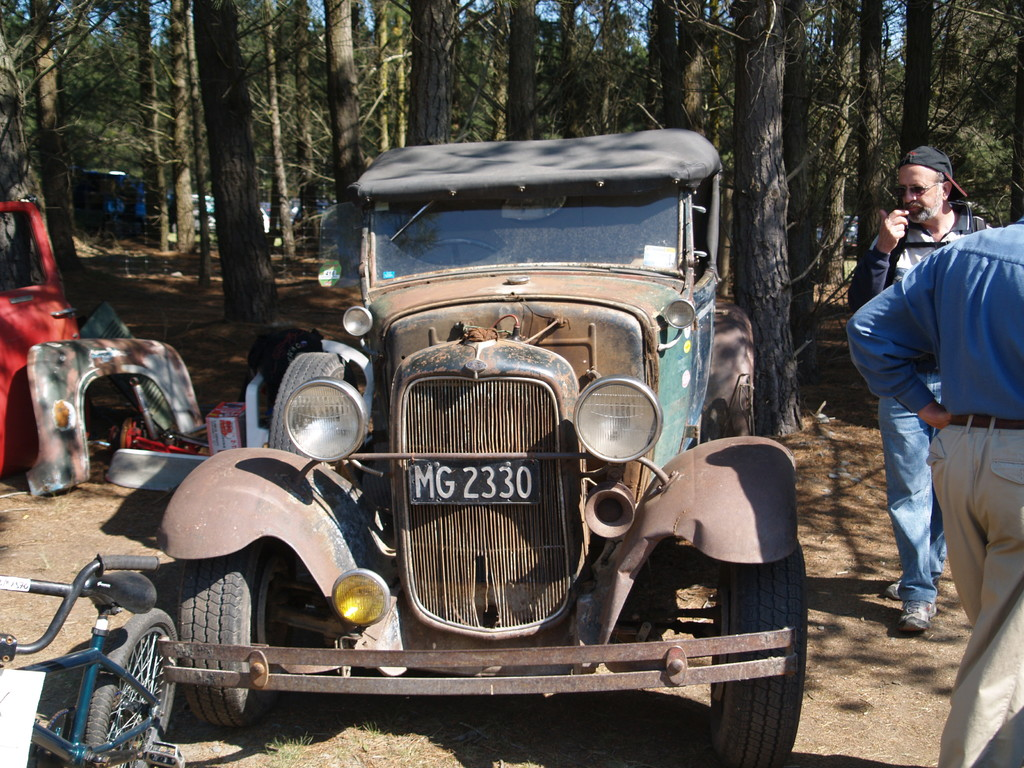

In [12]:
Image('/content/yolov5/trainval/images/image_000000001.jpg')

In [13]:
# df_Train, df_Valid = train_test_split(dfTrain, test_size = 0.2, shuffle = True, random_state= 1 )
totalImages = len ( dfTrain.file_name.unique() )
totalImages
allfiles = list( dfTrain.file_name.unique() )
random.seed(3)
trfiles = random.sample(allfiles, int( totalImages *0.8 )  )
# vafiles = set(allfiles)- set(trfiles)

In [14]:
# make train and valid from the random samples
df_Train = dfTrain[ dfTrain['file_name'].isin(trfiles) ]
df_Valid =  dfTrain[ ~dfTrain['file_name'].isin(trfiles) ]
df_Train.shape, df_Valid.shape

((3582, 5), (896, 5))

In [15]:
dfTrain[ dfTrain['file_name'] == 'image_000000001.jpg' ]

,file_name,category_id,width,height,bbox
0,image_000000001.jpg,1,1024,768,"[[846, 145, 146, 477], [848, 216, 175, 551]]"
1,image_000000001.jpg,2,1024,768,"[[74, 159, 75, 81], [153, 124, 658, 643]]"


In [16]:
import numpy as np
import shutil
import tqdm
DATA_PATH = '/content/yolov5/trainval/images/'
OUTPUT_PATH = '/content/yolov5/trainval/labels/'
def process_labels(data, data_type="train"):
  for _, row in   data.iterrows() :
    image_name = row['file_name'].replace('.jpg', '')
    bounding_boxes = row['bbox']
    yolo_data = []
    for bbox in bounding_boxes:
      x,y,w,h = bbox[0], bbox[1], bbox[2], bbox[3]
      x_center, y_center = x + w/2, y+ h/2
      x_center /= row['width']
      y_center /= row['height']
      w /=  row['width']
      h /= row['height']
      yolo_data.append([row['category_id']-1, x_center, y_center, w, h ])
    
    yolo_data = np.array(yolo_data)
    filename = os.path.join(OUTPUT_PATH, f"{data_type}/{image_name}.txt")

    if os.path.exists(filename):
      filename1 = filename+'1'
      np.savetxt( filename1
      , yolo_data
      ,fmt = ['%d', '%f', '%f','%f', '%f'] )

      with open( filename1, "r") as fin:
        data2 = fin.read()

      with open( filename , "a") as fout:
        fout.write(data2)

      os.remove(filename1)

    else:
      np.savetxt( filename 
      , yolo_data
      ,fmt = ['%d', '%f', '%f','%f', '%f'] )


def move_files(data, data_type="train"):
  for image_name in data.file_name.unique() :
    # image_name = row['file_name']
    try:
      shutil.copyfile( 
      os.path.join(DATA_PATH, f"{image_name}"),
      os.path.join(DATA_PATH, f"{data_type}/{image_name}")
      )
    except Exception as e:
      print(e)
    else:
      os.remove( os.path.join(DATA_PATH, f"{image_name}"))

In [17]:
%%bash
mkdir -p /content/yolov5/trainval/images/validation/
mkdir -p /content/yolov5/trainval/images/train/
mkdir -p /content/yolov5/trainval/labels/validation/
mkdir -p /content/yolov5/trainval/labels/train/

# rm -r /content/yolov5/trainval/images/validation/*
# rm -r /content/yolov5/trainval/labels/validation/*
# rm -r /content/yolov5/trainval/images/train/*
# rm -r /content/yolov5/trainval/labels/train/*

# Create the labels in correct Yolo format and save them in .txt files

In [18]:
process_labels(df_Valid, data_type='validation')
process_labels(df_Train, data_type='train')

## Move files into folders

In [19]:
move_files(df_Train, 'train')
move_files(df_Valid, 'validation')

## Upload the yaml file using the code shell below
- Then copy it to yolov5 folder

In [ ]:
from google.colab import files
uploaded = files.upload()

In [20]:
# !cp /content/trainCarHuman.yaml /content/yolov5/

In [21]:
%%capture
!pip install wandb
import wandb

In [22]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [25]:
# !cp /content/trainCarHuman.yaml /content/yolov5/

## Run YOLO train
- Not resizing images now, will do later. ( Resizing recommended according to documentation [here](https://github.com/ultralytics/yolov5)  )
- Running just for 3 epochs for now.

In [24]:
!python /content/yolov5/train.py --batch 16 --epochs 3 --data /content/yolov5/trainCarHuman.yaml --cfg /content/yolov5/models/yolov5s.yaml --name v0

wandb: Currently logged in as: vsnupoudel (use `wandb login --relogin` to force relogin)
train: weights=yolov5/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/yolov5/trainCarHuman.yaml, hyp=yolov5/data/hyps/hyp.scratch.yaml, epochs=3, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=yolov5/runs/train, name=v0, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-100-g5185981 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box

## Run detection with the trained weights
- Run the cell below to upload an image

In [25]:
from google.colab import files
uploaded = files.upload()

Saving Test.png to Test.png


In [26]:
!mkdir -p /content/test
#replace the filename below
!cp /content/Test.png  /content/test/

In [34]:
%%bash
python /content/yolov5/detect.py --weights /content/yolov5/runs/train/v0/weights/best.pt --img 416 --conf 0.1 --source /content/test/

detect: weights=['/content/yolov5/runs/train/v0/weights/best.pt'], source=/content/test/, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-100-g5185981 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/test/Test.png: 288x416 2 Persons, 1 Car, Done. (0.027s)
Speed: 0.3ms pre-process, 27.1ms inference, 1.9ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp6


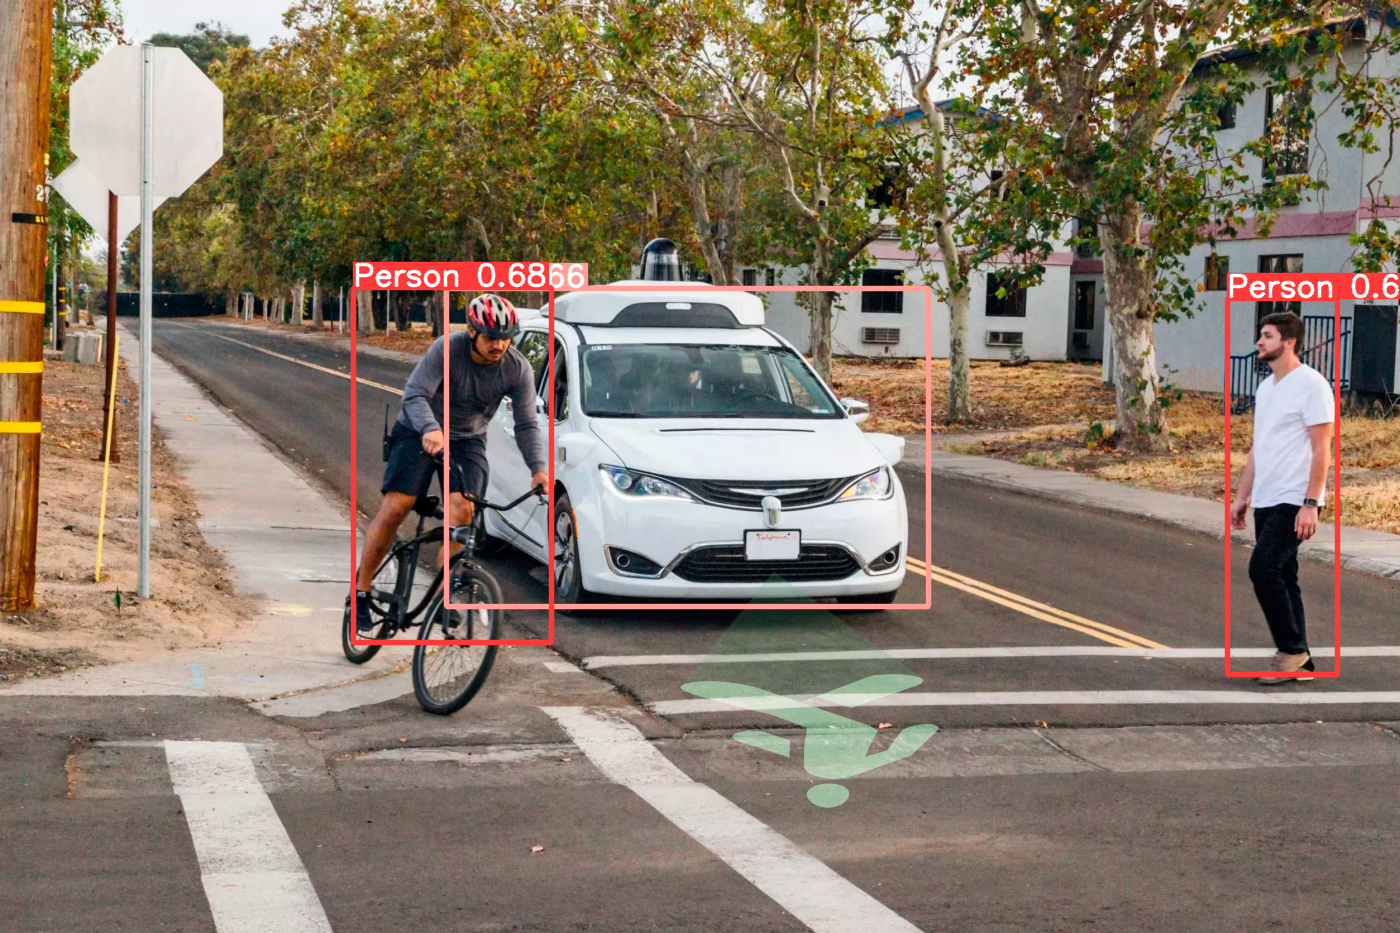

In [35]:
Image('/content/yolov5/runs/detect/exp6/Test.png')